In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn

zsh:1: command not found: pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv('cleaned_cancer_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Dataset shape: (569, 32)
Columns: ['Radius (mean)', 'Texture (mean)', 'Perimeter (mean)', 'Area (mean)', 'Smoothness (mean)', 'Compactness (mean)', 'Concavity (mean)', 'Concave points (mean)', 'Symmetry (mean)', 'Fractal dimension (mean)', 'Radius (se)', 'Texture (se)', 'Perimeter (se)', 'Area (se)', 'Smoothness (se)', 'Compactness (se)', 'Concavity (se)', 'Concave points (se)', 'Symmetry (se)', 'Fractal dimension (se)', 'Radius (worst)', 'Texture (worst)', 'Perimeter (worst)', 'Area (worst)', 'Smoothness (worst)', 'Compactness (worst)', 'Concavity (worst)', 'Concave points (worst)', 'Symmetry (worst)', 'Fractal dimension (worst)', 'Diagnosis', 'Diagnosis_encoded']

First few rows:
   Radius (mean)  Texture (mean)  Perimeter (mean)  Area (mean)  \
0      -0.166799       -1.147162         -0.185728    -0.251957   
1      -0.297446       -0.833008         -0.261106    -0.383638   
2      -1.313080       -1.593959         -1.302806    -1.083572   
3      -0.311646       -0.202373         

In [6]:
print("Data Info:")
print(df.info())
print(f"\nTarget variable distribution:")
print(df['Diagnosis'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         569 non-null    int64  
 1   Diagnosis                  569 non-null    object 
 2   Radius (mean)              569 non-null    float64
 3   Texture (mean)             569 non-null    float64
 4   Perimeter (mean)           569 non-null    float64
 5   Area (mean)                569 non-null    float64
 6   Smoothness (mean)          569 non-null    float64
 7   Compactness (mean)         569 non-null    float64
 8   Concavity (mean)           569 non-null    float64
 9   Concave points (mean)      569 non-null    float64
 10  Symmetry (mean)            569 non-null    float64
 11  Fractal dimension (mean)   569 non-null    float64
 12  Radius (se)                569 non-null    float64
 13  Texture (se)               569 non-null

In [7]:
def clean_cancer_data(df):
    """Clean the cancer dataset"""
    df_clean = df.copy()
    
    # Remove ID column
    if 'Id' in df_clean.columns:
        df_clean = df_clean.drop('Id', axis=1)
        print("Removed ID column")
    
    # Encode target variable
    le = LabelEncoder()
    df_clean['Diagnosis_encoded'] = le.fit_transform(df_clean['Diagnosis'])
    print(f"Diagnosis encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    # Get feature columns
    feature_cols = [col for col in df_clean.columns if col not in ['Diagnosis', 'Diagnosis_encoded']]
    
    print(f"Number of features: {len(feature_cols)}")
    return df_clean, feature_cols, le

# Run the cleaning
df_clean, feature_columns, label_encoder = clean_cancer_data(df)

Removed ID column
Diagnosis encoding: {'B': np.int64(0), 'M': np.int64(1)}
Number of features: 30


In [8]:
# Check for outliers
def detect_outliers(df, features):
    outlier_counts = {}
    
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_counts[col] = outliers
    
    return outlier_counts

outliers = detect_outliers(df_clean, feature_columns)
outlier_df = pd.DataFrame(list(outliers.items()), columns=['Feature', 'Outliers'])
print("Features with most outliers:")
print(outlier_df.sort_values('Outliers', ascending=False).head(10))

Features with most outliers:
                      Feature  Outliers
13                  Area (se)        65
10                Radius (se)        38
12             Perimeter (se)        38
23               Area (worst)        35
14            Smoothness (se)        30
15           Compactness (se)        28
19     Fractal dimension (se)        28
18              Symmetry (se)        27
3                 Area (mean)        25
29  Fractal dimension (worst)        24


In [9]:
# Scale the features
X = df_clean[feature_columns]
y = df_clean['Diagnosis_encoded']

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=feature_columns,
    index=X.index
)

print("Features scaled!")
print(f"Original feature ranges:")
print(X.describe().loc[['min', 'max']].round(2))
print(f"\nScaled feature ranges:")
print(X_scaled.describe().loc[['min', 'max']].round(2))

Features scaled!
Original feature ranges:
     Radius (mean)  Texture (mean)  Perimeter (mean)  Area (mean)  \
min           6.98            9.71             43.79        143.5   
max          28.11           39.28            188.50       2501.0   

     Smoothness (mean)  Compactness (mean)  Concavity (mean)  \
min               0.05                0.02              0.00   
max               0.16                0.35              0.43   

     Concave points (mean)  Symmetry (mean)  Fractal dimension (mean)  ...  \
min                    0.0             0.11                      0.05  ...   
max                    0.2             0.30                      0.10  ...   

     Radius (worst)  Texture (worst)  Perimeter (worst)  Area (worst)  \
min            7.93            12.02              50.41         185.2   
max           36.04            49.54             251.20        4254.0   

     Smoothness (worst)  Compactness (worst)  Concavity (worst)  \
min                0.07            

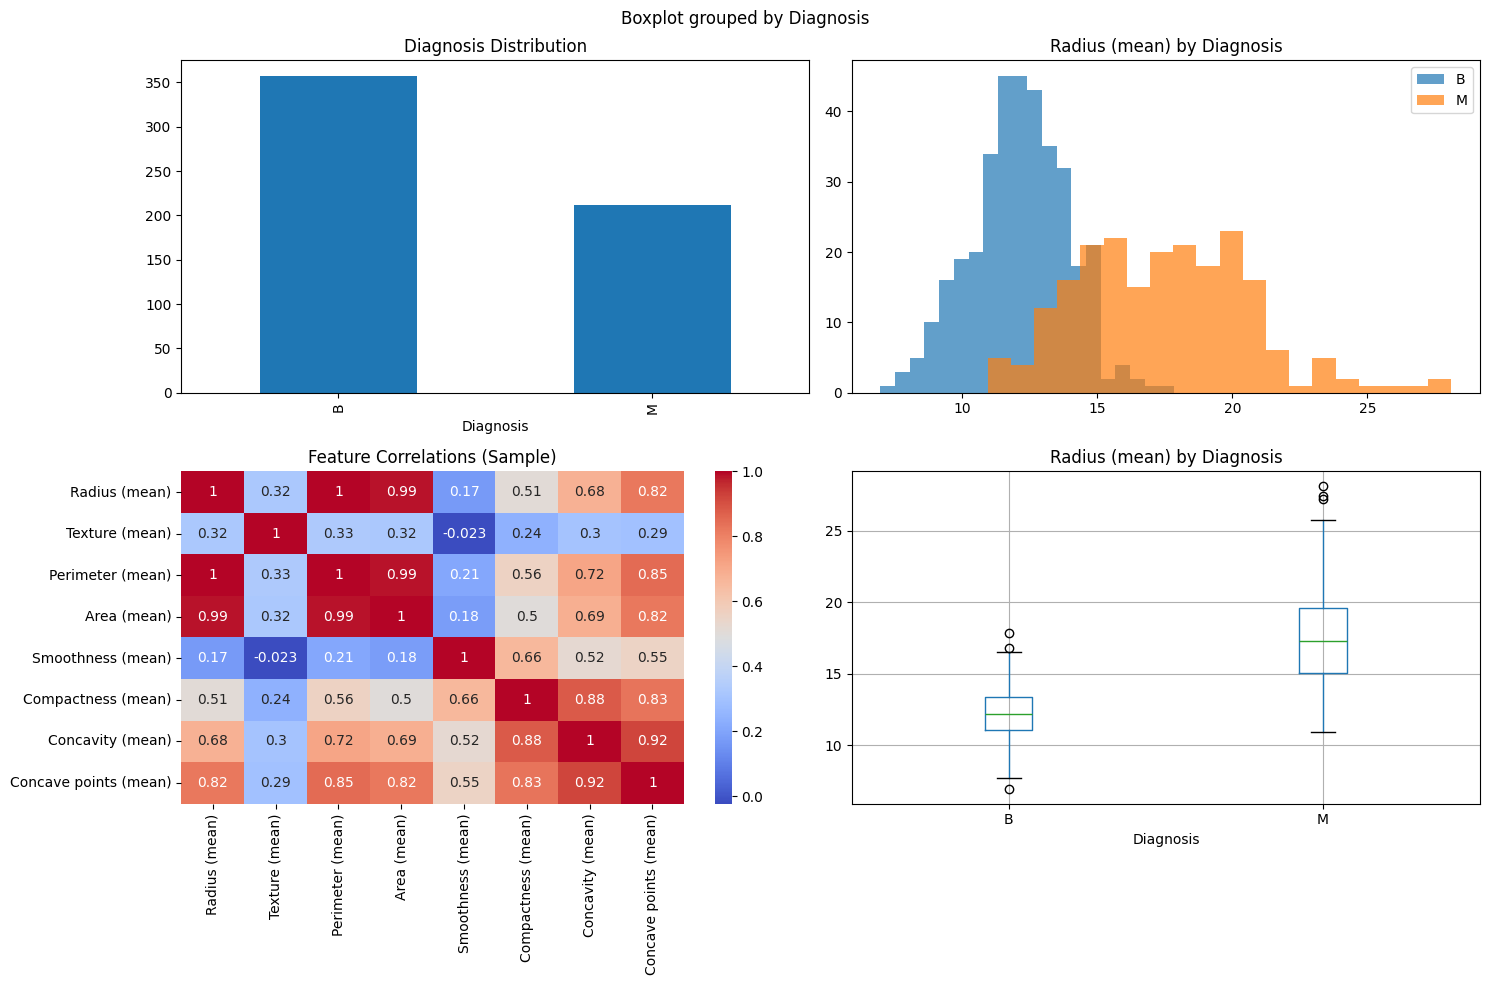

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
df_clean['Diagnosis'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Diagnosis Distribution')
axes[0,0].set_xlabel('Diagnosis')

# Feature distribution example
feature_example = feature_columns[0]
for diagnosis in df_clean['Diagnosis'].unique():
    subset = df_clean[df_clean['Diagnosis'] == diagnosis]
    axes[0,1].hist(subset[feature_example], alpha=0.7, label=diagnosis, bins=20)
axes[0,1].set_title(f'{feature_example} by Diagnosis')
axes[0,1].legend()

# Correlation heatmap (first 8 features)
sample_features = feature_columns[:8]
corr = df_clean[sample_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1,0])
axes[1,0].set_title('Feature Correlations (Sample)')

# Box plot example
df_clean.boxplot(column=feature_columns[0], by='Diagnosis', ax=axes[1,1])
axes[1,1].set_title(f'{feature_columns[0]} by Diagnosis')

plt.tight_layout()
plt.show()

In [11]:
# Prepare final datasets for modeling
print("Final cleaned data summary:")
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Save cleaned data if needed
df_final = pd.concat([X_scaled, df_clean[['Diagnosis', 'Diagnosis_encoded']]], axis=1)
df_final.to_csv('cleaned_cancer_data.csv', index=False)
print("Cleaned data saved to 'cleaned_cancer_data.csv'")

Final cleaned data summary:
Features shape: (569, 30)
Target shape: (569,)
Target distribution: {0: 357, 1: 212}
Cleaned data saved to 'cleaned_cancer_data.csv'


In [14]:
# Verify data is ready for modeling
print("Data verification:")
print(f"✓ No missing values: {X_scaled.isnull().sum().sum() == 0}")
print(f"✓ Features scaled: {abs(X_scaled.mean().mean()) < 0.1}")  # Should be close to 0
print(f"✓ Target encoded: {set(y.unique()) == {0, 1}}")
print(f"✓ Same number of samples: {len(X_scaled) == len(y)}")

print("\nYour data is ready for machine learning!")
print("Next steps: Train-test split, model selection, and evaluation")

Data verification:
✓ No missing values: True
✓ Features scaled: True
✓ Target encoded: True
✓ Same number of samples: True

Your data is ready for machine learning!
Next steps: Train-test split, model selection, and evaluation
